<a href="https://colab.research.google.com/github/DavidMCV97/debt_classification/blob/main/BBVA_discounts_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BBVA discounts analysis
First we make avaiable the dropbox files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we import the dataset and clean it

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/BBVA_activities(no_pilot).csv')
df = pd.DataFrame(df)
df['inicio_programa'] = pd.to_datetime(df.inicio_programa,format='%Y-%m-%d') # reads the date as a date
df['ultimo_pago'] = pd.to_datetime(df.ultimo_pago,format='%Y-%m-%d')
df['executed_date'] = pd.to_datetime(df.executed_date,format='%Y-%m-%d')
df[['bank_reference','debt_id','banco','num_tarjeta']] = df[['bank_reference','debt_id','banco','num_tarjeta']].astype(str) # cast to string
df.info() # returns a resume of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21854 entries, 0 to 21853
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bank_reference   21854 non-null  object        
 1   debt_id          21854 non-null  object        
 2   banco            21854 non-null  object        
 3   num_tarjeta      21854 non-null  object        
 4   deuda_resuelve   21854 non-null  float64       
 5   inicio_programa  21854 non-null  datetime64[ns]
 6   ultimo_pago      21854 non-null  datetime64[ns]
 7   executed_date    21854 non-null  datetime64[ns]
 8   pago_a_bancos    21854 non-null  float64       
dtypes: datetime64[ns](3), float64(2), object(4)
memory usage: 1.5+ MB


Now we select the debt tipe and add the bins

In [ ]:
import numpy as np
aux = df['num_tarjeta'].str.replace('\D', '', regex=True) # removes all letters with the \D and regex
aux_len = aux.str.len() # gets the length of the strings
df['bank_type'] = np.where((aux_len >= 15)&(aux_len <= 17), 'card','loan') # adds a column with two concepts under a condition
df['Bin'] = aux.str[:6] # returns the first 6 values of a string
df = df[df['bank_type'] == 'card'] # we select just the cards

Lets import the bins and check if they are registered.

In [ ]:
bins = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/BBVA_bins.csv')
bins = pd.DataFrame(bins)
bins['Bin'] = bins['Bin'].astype(str)
bins = bins.drop_duplicates('Bin') # returns a duplicate-free dataframe
df = pd.merge(df, bins, on = 'Bin', how = 'left') # left join on pandas
df['tasa'] = df['tasa'].fillna(0.04) #fills not founds (NaN)  with specified value.
df.head(10) # returns top 10 lines of the dataframe

,bank_reference,debt_id,banco,num_tarjeta,deuda_resuelve,inicio_programa,ultimo_pago,executed_date,pago_a_bancos,bank_type,Bin,tasa
0,10100904530,57764,BBVA,a5358750204939364,12284.00,2015-12-31,2015-11-10,2023-11-07,5619.0,card,535875,0.0400
1,10100904530,57764,BBVA,a5358750204939364,12284.00,2015-12-31,2015-11-10,2023-12-07,5619.0,card,535875,0.0400
2,10100904530,57764,BBVA,a5358750204939364,12284.00,2015-12-31,2015-11-10,2024-01-07,5619.0,card,535875,0.0400
3,10100904530,57764,BBVA,a5358750204939364,12284.00,2015-12-31,2015-11-10,2024-02-05,5619.0,card,535875,0.0400
4,10100957413,74883,BBVA,a5358750207327104,44736.87,2016-03-08,2016-01-12,2023-11-07,20130.0,card,535875,0.0400
5,10100957413,74883,BBVA,a5358750207327104,44736.87,2016-03-08,2016-01-12,2023-12-14,3800.0,card,535875,0.0400
6,10101015039,74918,BBVA,a4772133006666306,65769.05,2016-05-18,2016-04-01,2023-11-07,21049.0,card,477213,0.0375
7,10101015039,74918,BBVA,a4772133006666306,65769.05,2016-05-18,2016-04-01,2023-12-07,21049.0,card,477213,0.0375
8,10101015039,74918,BBVA,a4772133006666306,65769.05,2016-05-18,2016-04-01,2024-01-07,21049.0,card,477213,0.0375
9,10101015039,74918,BBVA,a4772133006666306,65769.05,2016-05-18,2016-04-01,2024-02-05,21049.0,card,477213,0.0375


lets check the date differences. we define the maximum interest period.

In [ ]:
max_period = 18 # max period of intrest grow

df['deliq_beginning_prog'] = (df['inicio_programa'].dt.year - df['ultimo_pago'].dt.year)*12 + df['inicio_programa'].dt.month - df['ultimo_pago'].dt.month #dt lets you get date values
df['deliq_beginning_prog'] = np.where(df['deliq_beginning_prog'] < 0, 0, df['deliq_beginning_prog']) # if negative, 0
df['deliq_act'] = (df['executed_date'].dt.year - df['ultimo_pago'].dt.year)*12 + df['executed_date'].dt.month - df['ultimo_pago'].dt.month
df['aux_balance'] = np.where(df['deliq_beginning_prog'] > max_period, 0, # 'where' is an if condition for dataframe columns
                    np.where(df['deliq_act'] > max_period, max_period - df['deliq_beginning_prog'],
                             df['deliq_act'] - df['deliq_beginning_prog']))

now we can calculate the balance and the real discount.

In [ ]:
df['balance'] = df['deuda_resuelve']*(1 + df['tasa'])**(df['aux_balance'])
df['real_discount'] = 1-df['pago_a_bancos']/df['balance']
df.head(5)

,bank_reference,debt_id,banco,num_tarjeta,deuda_resuelve,inicio_programa,ultimo_pago,executed_date,pago_a_bancos,bank_type,Bin,tasa,deliq_beginning_prog,deliq_act,aux_balance,balance,real_discount
0,10100904530,57764,BBVA,a5358750204939364,12284.00,2015-12-31,2015-11-10,2023-11-07,5619.0,card,535875,0.04,1,96,17,23928.009687,0.765171
1,10100904530,57764,BBVA,a5358750204939364,12284.00,2015-12-31,2015-11-10,2023-12-07,5619.0,card,535875,0.04,1,97,17,23928.009687,0.765171
2,10100904530,57764,BBVA,a5358750204939364,12284.00,2015-12-31,2015-11-10,2024-01-07,5619.0,card,535875,0.04,1,98,17,23928.009687,0.765171
3,10100904530,57764,BBVA,a5358750204939364,12284.00,2015-12-31,2015-11-10,2024-02-05,5619.0,card,535875,0.04,1,99,17,23928.009687,0.765171
4,10100957413,74883,BBVA,a5358750207327104,44736.87,2016-03-08,2016-01-12,2023-11-07,20130.0,card,535875,0.04,2,94,16,83791.318503,0.759760


now lets import the discounts projected for this debts

<function matplotlib.pyplot.show(close=None, block=None)>

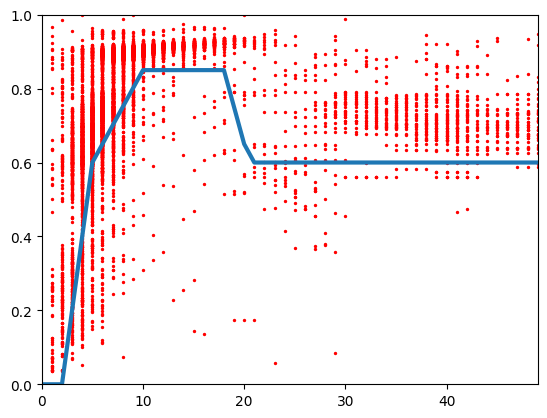

In [ ]:
import matplotlib.pyplot as plt
discounts = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/discounts.csv'))
discounts = discounts[discounts['bank'] == 'Tarjeta BBVA'] #we select only the interest discount function
discounts = discounts.transpose()
discounts.columns = ['proj_discount'] # we can get and change column names with .columns
discounts = discounts.drop('bank') #drop removes rows or columns.
discounts['deliquency'] = discounts.index.astype(int) # index gets the name of the rows.

plt.plot(discounts['deliquency'],discounts['proj_discount'],linewidth = 3) #plot is a line plot
plt.ylim(0,1) # y axis size
plt.xlim(0,49) # x axis size
plt.scatter(df['deliq_act'],df['real_discount'], s = 2,color='red') # histogram plot
plt.show # print the plot

lets see wich projected discount corresponds to every debt and see the error rate

In [ ]:
df = pd.merge(df,discounts,left_on="deliq_act",right_on="deliquency",how='left')
df = df.drop('deliquency',axis = 1) # merge sometimes returns a repeated column, so we erase it
df['proj_discount'] = df['proj_discount'].fillna(0.7)
df['proj_payment'] = df['balance']*(1-df['proj_discount']) # dont forget the 1-x!
df['error'] = (df['proj_payment'] - df['pago_a_bancos'])/df['proj_payment'] #error is measured using first known value; the projection.

Now lets see how the results look!

we had 91.32% of debts correctly forecasted.


<function matplotlib.pyplot.show(close=None, block=None)>

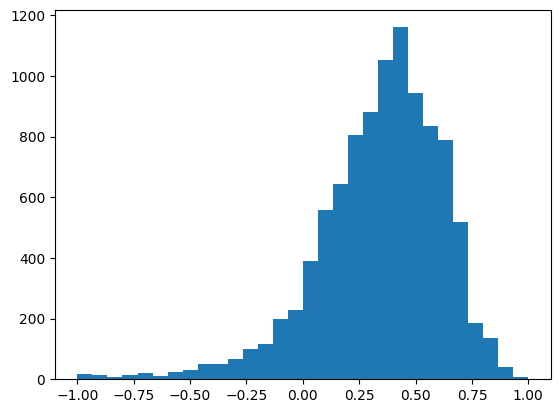

In [ ]:
precision = len(df[df['error'] >= -0.05])/len(df) # positive values are the good ones
print("we had",'{:.2f}%'.format(precision*100) + " of debts correctly forecasted.") # .format lets you format numbers for printing

plt.hist(df['error'],range=[-1,1],bins=30)
plt.show

We will have 5 categories of discounts based on the error

*   far below (<-30%)
*   below (<-5%)
*   good (<5%)
*   better (<30%)
*   far better (<100%)



In [ ]:
df['discount_category'] = np.where(df['error'] < -0.3,"far below",
                          np.where(df['error'] < -0.05,"below",
                          np.where(df['error'] < 0.05,"good",
                          np.where(df['error'] < 0.3,"better", "far better"))))
df['month_code'] = df['executed_date'].dt.year.astype(str) + df['executed_date'].dt.month.apply('{:0>2}'.format)

Now lets built a debts dataframe with their monthly debt category

In [ ]:
debts = df.drop_duplicates('debt_id')['debt_id']
for m in ['202311','202312','202401','202402']:
  debts = pd.merge(debts,
                     df[df['month_code'] == m][['debt_id','discount_category']],
                     how='left').fillna('no activity')
  debts = debts.rename(columns = {'discount_category':m})

We will have 7 debt categories depending on their discount history:

*   Far better debt (at least two far better, no below)
*   better debt (at least two better or one far better, no below)
*   good debt (at least one good or better or one better, at much one below)
*   below debt (more than one below, at much one far below)
*   far below debt (more than one far below)
*   dangerous debt (only one activity wich is far below)
*   not enough info (less than two activities and no dangerous)

In [ ]:
debts = debts.set_index('debt_id') # transform a column into the dataframe index
debts['debt_category'] = '' # creates a column with empty text values
for di in debts.index: #di is for debt id
  history = debts.loc[di].values.tolist()[:-1] # we slice the values to get just the discount categories
  if len(history) - history.count('no activity') < 2:
    if history.count('far below') > 0: debts.loc[di,'debt_category'] = 'dangerous'
    elif history.count('far better') > 0: debts.loc[di,'debt_category'] = 'potential'
    else: debts.loc[di,'debt_category'] = 'not enough info'
  elif history.count('far below') > 1: debts.loc[di,'debt_category'] = 'far below'
  elif history.count('below') > 1 or history.count('far below') > 0: debts.loc[di,'debt_category'] = 'below'
  elif history.count('below') > 0: debts.loc[di,'debt_category'] = 'good'
  elif history.count('far better') > 1: debts.loc[di,'debt_category'] = 'far better'
  elif history.count('better') > 1 or history.count('far better') > 0:  debts.loc[di,'debt_category'] = 'better'
  elif history.count('good') > 1 or history.count('better') > 0: debts.loc[di,'debt_category'] = 'good'

In [ ]:
debts

,202311,202312,202401,202402,debt_category
debt_id,,,,,
57764,better,better,better,better,better
74883,better,far better,no activity,no activity,better
74918,far better,far better,far better,far better,far better
241614,below,below,below,below,below
65066,far better,no activity,no activity,no activity,potential
...,...,...,...,...,...
1429106,no activity,no activity,no activity,better,not enough info
1430073,no activity,no activity,no activity,far better,potential
1430238,no activity,no activity,no activity,better,not enough info


In [ ]:
debts.groupby(['debt_category']).count()

,202311,202312,202401,202402
debt_category,,,,
below,209,209,209,209
better,745,745,745,745
dangerous,81,81,81,81
far below,62,62,62,62
far better,1669,1669,1669,1669
good,247,247,247,247
not enough info,601,601,601,601
potential,822,822,822,822


Now we will merge the debt categorie with the discounts to see how they look!

<ipython-input-20-d994847450f4>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1) # we make the first subplot
<ipython-input-20-d994847450f4>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,2)
<ipython-input-20-d994847450f4>:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,3)


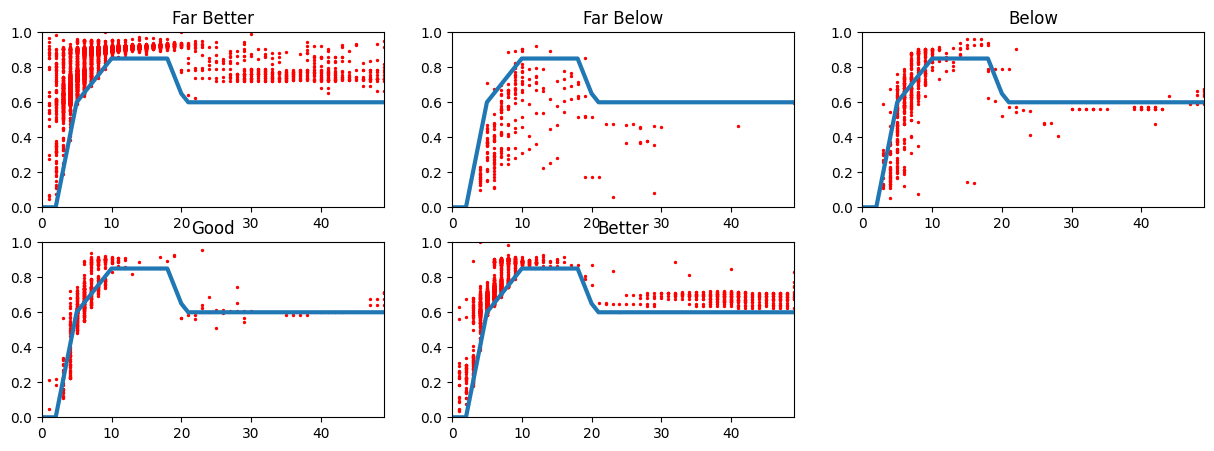

<Figure size 3000x480 with 0 Axes>

In [ ]:
df = pd.merge(df,debts['debt_category'], left_on='debt_id',right_index=True,how='left')
df_far_better = df[(df['debt_category'] == 'far better') | (df['debt_category'] == 'potential')] # | means or
df_far_below = df[(df['debt_category'] == 'far below') | (df['debt_category'] == 'dangerous')]
df_below = df[df['debt_category'] == 'below']
df_good = df[df['debt_category'] == 'good']
df_better = df[df['debt_category'] == 'better']

fig, ax = plt.subplots(1, 3, figsize=(15,5))

plt.subplot(2,3,1) # we make the first subplot
plt.plot(discounts['deliquency'],discounts['proj_discount'],linewidth = 3) #plot is a line plot
plt.ylim(0,1) # y axis size
plt.xlim(0,49) # x axis size
plt.scatter(df_far_better['deliq_act'],df_far_better['real_discount'], s = 2,color='red') # histogram plot
plt.title('Far Better')

plt.subplot(2,3,2)
plt.plot(discounts['deliquency'],discounts['proj_discount'],linewidth = 3) #plot is a line plot
plt.ylim(0,1) # y axis size
plt.xlim(0,49) # x axis size
plt.scatter(df_far_below['deliq_act'],df_far_below['real_discount'], s = 2,color='red') # histogram plot
plt.title('Far Below')

plt.subplot(2,3,3)
plt.plot(discounts['deliquency'],discounts['proj_discount'],linewidth = 3) #plot is a line plot
plt.ylim(0,1) # y axis size
plt.xlim(0,49) # x axis size
plt.scatter(df_below['deliq_act'],df_below['real_discount'], s = 2,color='red') # histogram plot
plt.title('Below')

plt.subplot(2,3,4)
plt.plot(discounts['deliquency'],discounts['proj_discount'],linewidth = 3) #plot is a line plot
plt.ylim(0,1) # y axis size
plt.xlim(0,49) # x axis size
plt.scatter(df_good['deliq_act'],df_good['real_discount'], s = 2,color='red') # histogram plot
plt.title('Good')

plt.subplot(2,3,5)
plt.plot(discounts['deliquency'],discounts['proj_discount'],linewidth = 3) #plot is a line plot
plt.ylim(0,1) # y axis size
plt.xlim(0,49) # x axis size
plt.scatter(df_better['deliq_act'],df_better['real_discount'], s = 2,color='red') # histogram plot
plt.title('Better')


plt.figure().set_figwidth(30)
plt.show()

In [ ]:
#df.to_excel('/content/drive/MyDrive/Colab Notebooks/results/bbva_burned_debts.xlsx')